In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import pickle


from model import get_model
from utills import rearrange, load_data, extract_piece, swap_piece
model_pkl_file = "cheque_classifier_model.pkl"

In [3]:
base_path = 'data/cheq_2x2/'

## Defining essential variables

In [4]:
cuts = 2    
channel = 3
im_size = 200

## Load pretrained model, you can download the model from [here](https://www.floydhub.com/shivaverma/workspaces/run_LEzD4uEtzqggKf5p2risz7NE)

In [14]:
# model = keras.models.load_model('model/jigsaw.model')

## Or train from scratch model

In [4]:
model = get_model()

In [16]:
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam)

In [17]:
x_val,   y_val   = load_data(base_path, 'valid')
x_train, y_train = load_data(base_path, 'train')

In [18]:
model.fit(x_train, y_train, batch_size=16, epochs=8, validation_data=(x_val, y_val))

Epoch 1/8
1021/1021 [==============================] - 245s 238ms/step - loss: 0.0994 - val_loss: 0.1501
Epoch 2/8
1021/1021 [==============================] - 242s 237ms/step - loss: 0.0311 - val_loss: 0.0117
Epoch 3/8
1021/1021 [==============================] - 246s 241ms/step - loss: 0.0170 - val_loss: 0.0116
Epoch 4/8
1021/1021 [==============================] - 241s 236ms/step - loss: 0.0144 - val_loss: 0.0569
Epoch 5/8
1021/1021 [==============================] - 241s 236ms/step - loss: 0.0114 - val_loss: 0.0019
Epoch 6/8
1021/1021 [==============================] - 238s 233ms/step - loss: 0.0103 - val_loss: 0.0209
Epoch 7/8
1021/1021 [==============================] - 239s 234ms/step - loss: 0.0158 - val_loss: 0.0015
Epoch 8/8
1021/1021 [==============================] - 239s 234ms/step - loss: 0.0090 - val_loss: 0.0024


In [19]:

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\flatten
......vars
...layers\reshape
......vars
...layers\time_distributed
......vars
...layers\time_distributed\layer
......vars
...layers\time_distributed_1
......vars
...layers\time_distributed_10
......vars
...layers\time_distributed_10\layer
......vars
.........0
.........1
...layers\time_distributed_11
......vars
...layers\time_distributed_11\layer
......vars
.........0
.........1
.........2
.........3
...layers\time_distributed_12
......vars
...layers\time_distributed_12\layer
......vars
...layers\time_distributed_1\layer
.....

## Loading test data

In [5]:
x_test, y_test = load_data(base_path, 'test')

In [6]:
from IPython.display import clear_output

## Testing indivisual Image

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-11-19 19:46:58        10720
metadata.json                                  2023-11-19 19:46:58           64
variables.h5                                   2023-11-19 19:46:58     96774536
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\activation
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\flatten
......vars
...layers\reshape
......vars
...layers\time_distributed
......vars
...layers\time_distributed\layer
......vars
...layers\time_distributed_1
......vars
...layers\time_distri

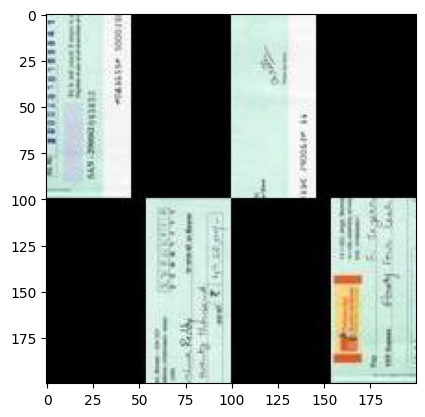

1/1 [==============================] - 0s 196ms/step


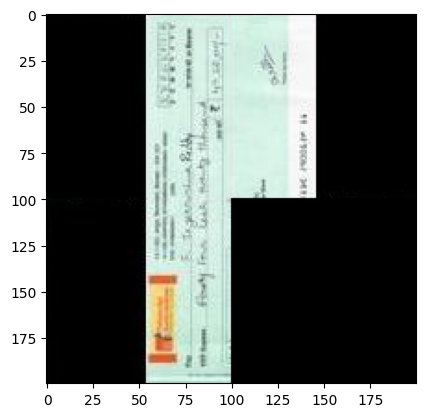

In [11]:
with open(model_pkl_file, 'rb') as file:
    model = pickle.load(file)
im = 316

plt.imshow(x_test[im].astype('float64')+.5)
plt.show()

inp = np.expand_dims(extract_piece(x_test[im]), axis=0)
out = model.predict(inp)[0]
out = np.argmax(out, axis=1)
rearrange(np.array(x_test[im])+.5, out)

## Testing all the test set

In [12]:
solved = 0
x_test_proc = []

for i in x_test:
    x_test_proc.append(extract_piece(i))
    
x_test_proc = np.array(x_test_proc) 
out = model.predict(x_test_proc)

for i in range(len(out)):
    pos = np.argmax(out[i], axis=1)
    if list(pos) == list(y_test[i].reshape(cuts*cuts)):
        solved += 1

print("Accuracy on {} samples: {}%".format(len(out), round((solved/i)*100, 2)))

12/12 [==============================] - 1s 91ms/step
Accuracy on 378 samples: 98.67%


## Correct prediction percentage for each position

In [13]:
all_val = []

for i in range(len(out)):

    pos = np.argmax(out[i], axis=1)
    val = (pos==y_test[i].reshape(cuts*cuts)).astype('int')    
    all_val.append(val)

all_val = np.array(all_val)
[round(i, 2) for i in (np.sum(all_val, axis=0)/len(out))*100]

[98.68, 99.21, 99.21, 99.21]